# Preliminary Analysis

An initial objective will be to verify that the causal relation between exchange flows from main crypto markets and price returns (for BTC and ETH) holds also for the dataset that we are going to use (which includes more recent data than previous studies on the topic).
* Exploratory analysis of the dataset: summary statistics for each feature across exchanges and for both currencies, Jarque-Bera normality test and Augmented dickey Fuller stationarity test, correlation analysis (+ commentary on the results found)
* Linear regression analysis between features with different lags and across exchanges
* Granger-causality between features and across exchanges

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Summary Statistics

RET: daily log return <br>
<s>VOL: daily trading volume</s> <br>
NET: daily net flow (inflow minus outflow) <br>
9 exchanges: Binance, Bitfinex, Bitmex, Bitstamp, Bittrex, Huobi, Kraken, Kucoin, and Poloniex

In [2]:
## import raw data
btc_d = pd.read_csv('data/btc_daily_data.csv')
eth_d = pd.read_csv('data/eth_daily_data.csv')
#btc_h = pd.read_csv('data/btc_hourly_data.csv')
#eth_h = pd.read_csv('data/eth_hourly_data.csv')

In [3]:
## clean Bitcoin data 
exch = ['binance', 'bitfinex', 'bitmex', 'bitstamp', 'bittrex', 'gemini', 'huobi', 'kraken', 'poloniex']
btc = pd.DataFrame(index=btc_d['date']) 
btc['RET'] = np.log(btc_d['close']/btc_d['close'].shift(1)).tolist() # daily log return
for exchange in exch:
    #btc['VOL.{}'.format(exchange)]=(btc_d['exch.{}.flow.in.ntv'.format(exchange)]+
                                    #btc_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()
    btc['NET.{}'.format(exchange)]=(btc_d['exch.{}.flow.in.ntv'.format(exchange)]-
                                    btc_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()

In [4]:
## clean Ethereum data
exch = ['binance', 'bitfinex', 'bitstamp', 'bittrex', 'gemini', 'kraken', 'poloniex'] # no data for bitmex and huobi
eth = pd.DataFrame(index=eth_d['date']) 
eth['RET'] = np.log(eth_d['close']/eth_d['close'].shift(1)).tolist() # daily log return
for exchange in exch:
    eth['NET.{}'.format(exchange)]=(eth_d['exch.{}.flow.in.ntv'.format(exchange)]-
                                    eth_d['exch.{}.flow.out.ntv'.format(exchange)]).tolist()

In [5]:
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

def stylizedfacts(ts):
    ts = ts.dropna() 
    ts = ts[ts != 0]
    Mean = ts.mean()
    Std = ts.std()
    Min = ts.min()
    Median = ts.median()
    Max = ts.max()
    JB = round(jarque_bera(ts).statistic,4)
    JB_pval = jarque_bera(ts).pvalue
    if JB_pval <= 0.01:
        JB = f'{JB}***'
    elif 0.01 < JB_pval <= 0.05:
        JB = f'{JB}**'
    elif 0.05 < JB_pval <= 0.1:
        JB = f'{JB}*'
    adf = round(adfuller(ts)[0],4)
    adf_pval = adfuller(ts)[1]
    if adf_pval <= 0.01:
        adf = f'{adf}***'
    elif 0.01 < adf_pval <= 0.05:
        adf = f'{adf}**'
    elif 0.05 < adf_pval <= 0.1:
        adf = f'{adf}*'
    output = pd.Series([Mean, Std, Min, Median, Max, JB, adf])
    return output

In [6]:
multindex = [
    np.array(["BTC"]*btc.shape[1] + ["ETH"]*eth.shape[1]),
    np.array(btc.columns.tolist() + eth.columns.tolist()),
]
stat = pd.DataFrame(index=multindex, columns=['Mean', 'Std', 'Min', 'Median', 'Max', 'JB', 'ADF']) 

for col in btc.columns:
    stat.loc[('BTC',col)] = stylizedfacts(btc[col]).tolist()
    
for col in eth.columns:
    stat.loc[('ETH',col)] = stylizedfacts(eth[col]).tolist()

display(stat)

Mean           Std             Min       Median  \
BTC RET              0.002207      0.042019       -0.479934      0.00218   
    NET.binance    288.233461   2890.257578   -27245.169933   145.112552   
    NET.bitfinex     0.030217   4639.877883  -114362.436427    32.024808   
    NET.bitmex      56.959934    1888.97536   -34096.929705    52.944745   
    NET.bitstamp  -261.741532   2172.746725   -30531.728449  -153.417498   
    NET.bittrex     -62.61707   1579.418656   -11265.461988   -59.163814   
    NET.gemini      53.664843   2112.698987   -16424.057375    21.083085   
    NET.huobi      -31.454771   2518.697052   -26518.490634     50.35964   
    NET.kraken    -277.201507   3096.580479   -40168.725188  -100.529798   
    NET.poloniex   -48.658665   1754.127031   -19364.006567    -57.99326   
ETH RET              0.002826      0.057639       -0.569507     0.000926   
    NET.binance   2569.638457  52020.986735   -539884.30289   -57.761395   
    NET.bitfinex   -22.555943  70234.414299  -995304.971652   409.738149   
    NET.bitstamp   426.350664   12547.05459  -201171.103685    240.92487   
    NET.bittrex    491.323208  10544.292642  -163193.049145  -250.780967   
    NET.gemini     549.087312  25369.545052  -231237.108676    -43.18483   
    NET.kraken   -2972.772355  35878.009401  -744418.305422 -2414.850456   
    NET.poloniex  -4070.32535   76326.35585 -1224401.233088 -1232.750866   

                             Max               JB          ADF  
BTC RET                 0.227618    11056.5197***  -29.7557***  
    NET.binance     26273.320001    26951.4617***   -8.3145***  
    NET.bitfinex     32536.40393  3265468.3234***  -11.9705***  
    NET.bitmex      25151.010367   657710.7445***  -13.0258***  
    NET.bitstamp    14668.299449   154533.0908***  -43.0309***  
    NET.bittrex     19345.994173    48768.3862***   -6.6868***  
    NET.gemini      32811.067196   180142.7459***    -7.785***  
    NET.huobi       25256.626211    40478.2066***  -13.1746***  
    NET.kraken      38112.388789    198937.533***  -10.2877***  
    NET.poloniex    13766.676194    31865.3992***   -8.9557***  
ETH RET                 0.260244     5242.9865***   -12.549***  
    NET.binance    424515.823542     52694.739***  -16.9739***  
    NET.bitfinex   575011.437727   293523.8111***  -25.4746***  
    NET.bitstamp    80055.821536    263837.119***  -10.0918***  
    NET.bittrex     94608.848902   161103.8506***  -10.6772***  
    NET.gemini     285607.359589    97772.2293***    -8.274***  
    NET.kraken      398444.26238  1204296.4067***   -6.5217***  
    NET.poloniex  1553929.089877   2169504.002***  -13.7691***

The symbols \*, \*\*, and \*\*\* denote the rejection of the null hypothesis (normal and unit root/non-stationary) at the 10%, 5%, and 1% significance levels.

In [ ]:
print(stat.to_latex(index=True))  

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(btc.corr(), annot=True).set_title('BTC Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

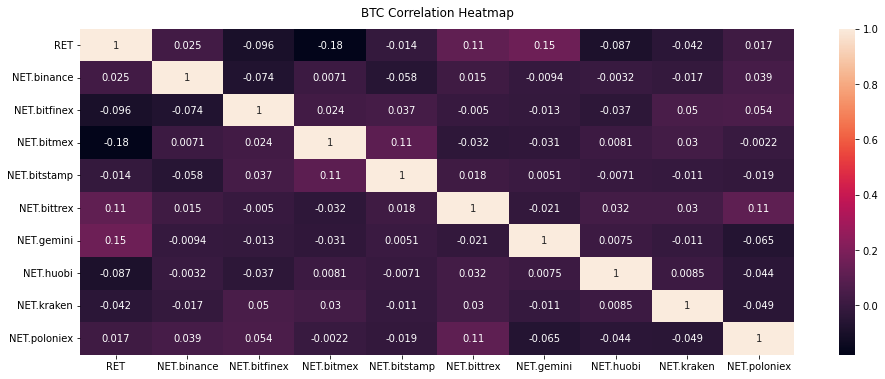

In [7]:
plt.figure(figsize=(16, 6))
sns.heatmap(btc[(btc!=0).all(1)].dropna().corr(), annot=True).set_title('BTC Correlation Heatmap', 
                                                                        fontdict={'fontsize':12}, pad=12)
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(eth.corr(), annot=True).set_title('ETH Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

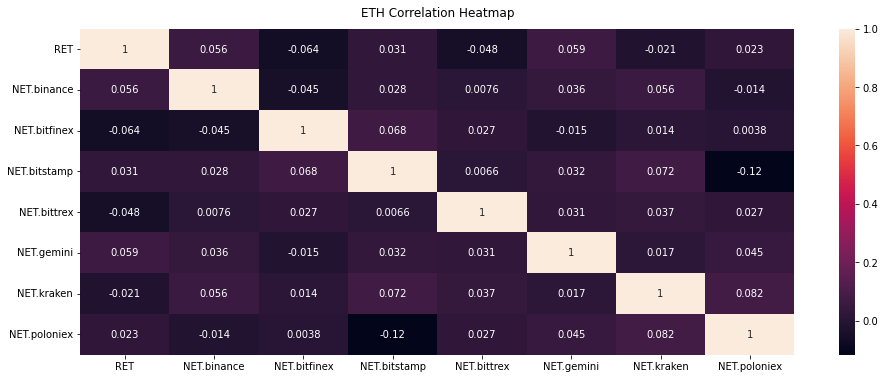

In [8]:
plt.figure(figsize=(16, 6))
sns.heatmap(eth[(eth!=0).all(1)].dropna().corr(), annot=True).set_title('ETH Correlation Heatmap', 
                                                                        fontdict={'fontsize':12}, pad=12)
plt.show()

## 2. Vector Autoregression (VAR)

VAR between return and net flow among the exchanges <br>

$$ \text{VAR(3):  } Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \phi_3 Y_{t-3} + \epsilon_t $$
L1 - one lag 

In [9]:
from statsmodels.tsa.api import VAR

In [10]:
#btc_data = btc.dropna()
btc_data = btc[(btc!=0).all(1)].dropna()
model = VAR(btc_data)
results = model.fit(3) # order: 3 lags
param = round(results.params,4)
pval = results.pvalues

/Users/wexu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [11]:
btc_VAR_res = pd.DataFrame(index=param.index, columns=param.columns)
for col in param.columns:
    for row in param.index:
        if pval[col].loc[row] <= 0.01:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}***'
        elif 0.01 < pval[col].loc[row] <= 0.05:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}**'
        elif 0.05 < pval[col].loc[row] <= 0.1:
            btc_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}*'
        else:
            btc_VAR_res[col].loc[row] = param[col].loc[row]
btc_VAR_res = btc_VAR_res.drop(index='const')
display(btc_VAR_res)

,RET,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
L1.RET,-0.0618**,3164.3299*,-5273.9239**,-148.6244,1757.4659,-1863.7036*,4220.6364***,2745.9924**,-2137.0598,-115.6565
L1.NET.binance,-0.0,0.0814***,-0.0393,-0.0278,-0.0117,0.0236,0.0067,0.0398*,-0.0084,0.0194*
L1.NET.bitfinex,-0.0,0.022,0.0677**,0.055***,0.0085,0.0322***,0.0114,0.0058,0.0251,0.0256***
L1.NET.bitmex,0.0,0.0139,0.0499,0.203***,0.0648**,0.0092,0.0643**,-0.045,0.0094,-0.0119
L1.NET.bitstamp,-0.0,0.0005,-0.0062,0.0384,0.0357,-0.0329,0.0243,0.0382,-0.1794***,0.0111
L1.NET.bittrex,0.0,0.1245***,-0.0251,-0.0451,-0.0038,0.2081***,-0.0242,-0.0637*,0.0349,0.0229
L1.NET.gemini,-0.0**,-0.0078,-0.0367,0.0276,0.0018,-0.0304,-0.0014,0.0389,0.0329,0.021
L1.NET.huobi,-0.0*,-0.0144,0.0303,-0.0062,0.0238,0.0207,0.0061,0.2466***,0.0885**,-0.019
L1.NET.kraken,0.0,-0.0027,0.0045,-0.0254,-0.0399**,-0.0013,-0.0308*,0.056***,0.1309***,0.0319***
L1.NET.poloniex,0.0,-0.0157,-0.1796**,0.0057,0.0648,0.0841**,0.0712,0.0144,0.1532**,0.0398


The symbols \*, \*\*, and \*\*\* denote the statistical insignificance at the 10%, 5%, and 1% levels

In [ ]:
print(btc_VAR_res.to_latex(index=True))  

In [12]:
#eth_data = eth.dropna()
eth_data = eth[(eth!=0).all(1)].dropna()
model = VAR(eth_data)
results = model.fit(3) # order: 3 lags
param = round(results.params,4)
pval = results.pvalues

/Users/wexu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [13]:
eth_VAR_res = pd.DataFrame(index=param.index, columns=param.columns)
for col in param.columns:
    for row in param.index:
        if pval[col].loc[row] <= 0.01:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}***'
        elif 0.01 < pval[col].loc[row] <= 0.05:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}**'
        elif 0.05 < pval[col].loc[row] <= 0.1:
            eth_VAR_res[col].loc[row] = f'{str(param[col].loc[row])}*'
        else:
            eth_VAR_res[col].loc[row] = param[col].loc[row]
eth_VAR_res = eth_VAR_res.drop(index='const')
display(eth_VAR_res)

,RET,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
L1.RET,-0.0728***,46199.6346*,-93789.6825***,6271.3433,-5661.3149,18317.107*,-12613.5049*,-12206.6076**
L1.NET.binance,-0.0,-0.0551**,-0.0252,0.0113*,0.0062,0.002,-0.0002,-0.0093*
L1.NET.bitfinex,0.0**,-0.0091,0.1782***,0.0052,-0.0071,-0.0148*,0.0037,-0.0039
L1.NET.bitstamp,0.0,0.1324,0.0135,-0.0334,0.0049,0.061,-0.0159,0.0769***
L1.NET.bittrex,-0.0,0.2403*,-0.0381,-0.0061,0.172***,-0.016,0.0017,-0.0515**
L1.NET.gemini,-0.0,-0.0309,-0.0452,-0.0079,-0.016,-0.0327,0.0333*,0.0085
L1.NET.kraken,-0.0,0.0977,-0.0834,0.0469**,0.0229,0.0195,0.183***,0.0683***
L1.NET.poloniex,0.0,0.0315,-0.2022,0.0205,-0.0173,-0.0499,0.126***,0.0506*
L2.RET,0.0911***,-791.8187,-35443.6046,3475.2886,-6876.9765,22295.9548**,-7227.6104,-10659.0803**
L2.NET.binance,-0.0,-0.0923***,0.004,-0.0031,-0.0071,0.0153,0.004,-0.0002


In [ ]:
print(eth_VAR_res.to_latex(index=True))  

## 3. Granger’s Causality

1. return and net flow
2. <s>return and volume </s>

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

**null hypothesis: Granger non causality** (time series in the second column does NOT Granger cause the time series in the first column) <br>
4 tests: params_ftest, ssr_ftest (based on F distribution); ssr_chi2test, lrtest (based on chi-square distribution)

In [15]:
def grangers_causality_pval(data,lag):
    res = pd.DataFrame(index=data.columns, columns=data.columns)
    test_list = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']
    for col in res.columns:
        for row in res.index:
            result = grangercausalitytests(data[[col, row]], # whether row variable granger cause column variable
                                         maxlag=lag, verbose=False) 
            # result[lag][0-summary][test][0-statistics,1-pval,2-DOF]
            minpval = np.min([np.min([round(result[i+1][0][test][1],6) for i in range(lag)]) # min pval of each test
                              for test in test_list]) # min pvalue of all test
            if minpval <= 0.01:
                res.loc[row,col] = f'{minpval}***' 
            elif 0.01 < minpval <= 0.05:
                res.loc[row,col] = f'{minpval}**' 
            elif 0.05 < minpval <= 0.1:
                res.loc[row,col] = f'{minpval}*' 
            else:
                res.loc[row,col] = minpval
            if row == col:
                res.loc[row,col] = '-'
    return res

In [16]:
btc_GC_res = grangers_causality_pval(btc_data,3)
display(btc_GC_res)

,RET,NET.binance,NET.bitfinex,NET.bitmex,NET.bitstamp,NET.bittrex,NET.gemini,NET.huobi,NET.kraken,NET.poloniex
RET,-,0.049016**,0.001713***,0.635722,0.437802,0.00316***,0.0***,0.017648**,0.135774,0.233845
NET.binance,0.348847,-,0.11737,0.071526*,0.64524,0.172107,0.404305,0.154536,0.660053,0.10286
NET.bitfinex,0.104616,0.391269,-,8.6e-05***,0.482936,0.00059***,0.959539,0.800348,0.204147,0.003524***
NET.bitmex,0.507477,0.938791,0.06731*,-,0.019304**,0.253536,0.031659**,0.096824*,0.919948,0.483579
NET.bitstamp,0.102997,0.969461,0.597592,0.060976*,-,0.139962,0.062385*,0.173944,0.0***,0.0***
NET.bittrex,0.156847,0.002483***,0.060562*,0.108312,0.225464,-,0.132006,0.206251,0.148716,0.085315*
NET.gemini,0.007427***,0.155585,0.104796,0.286668,0.775665,0.04279**,-,0.038551**,0.145987,0.105745
NET.huobi,0.04631**,0.53929,0.248851,0.692078,0.200229,0.031331**,0.864316,-,0.000931***,0.042232**
NET.kraken,0.526546,0.835998,0.260722,0.210812,0.00486***,0.285007,0.014047**,0.000407***,-,7e-05***
NET.poloniex,0.02427**,0.787403,0.020662**,0.831624,0.008263***,0.005581***,0.073462*,0.001832***,0.005639***,-


Note: the asterisk sign shows the row variable Granger cause the column variable (dependent variable). <br> \*, \*\*, and \*\*\* denote significance at the 10%, 5%, and 1% levels respectively.

In [ ]:
print(btc_GC_res.to_latex(index=True))  

In [17]:
eth_GC_res = grangers_causality_pval(eth_data,3)
display(eth_GC_res)

,RET,NET.binance,NET.bitfinex,NET.bitstamp,NET.bittrex,NET.gemini,NET.kraken,NET.poloniex
RET,-,0.050319*,0.001058***,0.146972,0.42764,0.010575**,0.085471*,0.001259***
NET.binance,0.02895**,-,0.152608,0.037724**,0.219838,0.238814,0.886364,0.120216
NET.bitfinex,0.056508*,0.125195,-,0.00136***,0.088291*,0.03515**,0.021239**,0.715141
NET.bitstamp,0.003806***,0.042343**,0.01815**,-,0.000849***,0.063302*,0.303679,2.9e-05***
NET.bittrex,0.556499,0.060848*,0.259556,0.182849,-,0.573513,0.704074,0.019448**
NET.gemini,0.065366*,0.293681,0.259403,0.51244,0.201373,-,0.062928*,0.74592
NET.kraken,0.047255**,0.337277,0.213914,0.001307***,0.226633,0.481883,-,1e-06***
NET.poloniex,0.456761,0.732104,0.415123,0.517986,0.251776,0.173272,0.000257***,-


In [ ]:
print(eth_GC_res.to_latex(index=True))  